### **Modeling the entire data**

In [1]:
# standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# NLP analysis imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# modeling imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from functions import model_scores # python file with a self-made function, saved in the code folder

---

In [2]:
# read the reddit_combined data
data = pd.read_csv('../data/data_reddit_combined.csv')

In [3]:
data.head()

,subreddit,selftext,title,created_utc,combined_text,word_count,char_count
0,books,And it's not because I'm a slow reader - quite...,"It's taken me all year, but I finally finished...",1577836753,And it's not because I'm a slow reader - quite...,197,1058
1,books,Those that scroll through reddit AND read so m...,How do you find the time?,1577835261,Those that scroll through reddit AND read so m...,28,138
2,books,What’s everyone’s reading goals for next year?...,2020 reading goals,1577834790,What’s everyone’s reading goals for next year?...,20,114
3,books,Has anyone read Cage of Souls and what did you...,Cage of Souls - Adrian Tchaikovsky,1577834642,Has anyone read Cage of Souls and what did you...,49,255
4,books,"For the past few years, one of my New Year's r...",Tracking the Books I Read In 2019,1577834517,"For the past few years, one of my New Year's r...",633,3820


In [4]:
# dependent variable is the column subreddit; transform it to 1 = datascience / 0 = books
data['y'] = data['subreddit'].map({'datascience':1, 'books':0})

In [5]:
# define X and y
X = data['combined_text']
y = data['y']

In [6]:
# baseline accuracy
y.value_counts(normalize=True) # baseline = 50% if taking combined_text as data

0    0.5
1    0.5
Name: y, dtype: float64

---

### **1. Count Vectorizer - Logistic Regression**

In [7]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [9]:
count = 0 # count variable for specifying the model ID

model_params = {} # dictionary that will contain model parameters

In [12]:
## set modeling scaffolding ##

model_params = model_params # each time it's run, the model_params dict gets overwritten
count = count # overwriting count with each run

# define a pipeline with 2 steps: CountVectorizer & LogisticRegression
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear'))
])

# set up the grid search parameters
params = {
    'cvec__max_features' : [7000,8000,9000],
    'cvec__min_df' : [3],
    'cvec__max_df' : [0.5],
    'cvec__ngram_range' : [(1,1)],
    'logreg__penalty' : ['l2'],
    'logreg__C' : [1]
}

# create grid search
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=6, verbose=1)

# fit the model
gs.fit(X_train, y_train)

# increase the count variable
count += 1

# add to the dictionary the best_params_ dictionary, in addition to the 'score'
gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_

# transform the params dictionary into a data frame, putting the model ID as the index
model_df = pd.DataFrame.from_dict(model_params, orient='index')

# print the data frame
model_df

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,cvec__stop_words,logreg__C,logreg__penalty,score
model_1,0.5,8000,3,"(1, 1)",NaN,1,l2,0.95537
model_2,0.5,8000,3,"(1, 1)",NaN,1,l2,0.95537


In [91]:
## Fit the best performing model - after tuning the hyperparameters several times in the cell above ##

# instantiate a cvec vectorizer
cvec = CountVectorizer(max_df = 0.5, min_df=3, max_features=8000, ngram_range=(1,1))

# apply cvec to the train data
X_train = cvec.fit_transform(X_train)

# apply cvec to the test data
X_test = cvec.transform(X_test)

In [92]:
# instantiate model
logreg = LogisticRegression(solver='liblinear', penalty='l2', C=1)

# fit model to the train data
logreg.fit(X_train, y_train)

LogisticRegression(C=1, solver='liblinear')

In [93]:
# training score
logreg.score(X_train, y_train)

0.9868859585567309

In [94]:
# testing score
logreg.score(X_test, y_test)

0.9583701088555457

In [16]:
# table of model scores - uses the function.py file in the code folder
model_scores(X_test, y_test, logreg)

,score,value
0,accuracy,0.958370
1,missclassification,0.041630
2,specificity,0.982642
3,recall_sensitivity,0.934098
4,precision,0.981756
5,f1,0.957335


In [17]:
# save the table into a csv file
df = model_scores(X_test, y_test, logreg)
df['vectorizer'] = 'CountVectorizer'
df['model'] = 'LogisticRegression'
df.to_csv('../model_scores/df_cvec_logreg.csv', index=False)

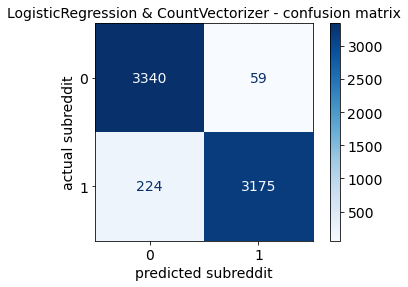

In [18]:
# plot and save the confusion matrix of the model
plt.rcParams.update({'font.size': 14});
plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', values_format='d');
plt.title('LogisticRegression & CountVectorizer - confusion matrix',fontsize=14);
plt.xlabel('predicted subreddit', fontsize=14);
plt.ylabel('actual subreddit', fontsize=14);
plt.savefig('../images/df_cvec_logreg.jpeg');

---

### **2. TF-IDF Vectorizer - Logistic Regression**

In [7]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [8]:
count = 0 # count variable for specifying the model ID

model_params = {} # dictionary that will contain model parameters

In [34]:
## set modeling scaffolding ##

model_params = model_params # each time it's run, the model_params dict gets overwritten
count = count # overwriting count with each run

# defining a pipeline with 2 steps: CountVectorizer & LogisticRegression
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear'))
])

# set up the grid search parameters
params = {
    'tvec__max_features' : [9000],
    'tvec__min_df' : [2],
    'tvec__max_df' : [0.5],
    'tvec__ngram_range' : [(1,1)],
    'logreg__penalty' : ['l2'],
    'logreg__C' : [1]
}

# create grid search
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=6, verbose=1)

# fitting the model
gs.fit(X_train, y_train)

# increase the count variable
count += 1

# adding to our dictionary the best_params_ dictionary, in addition to the 'score'
gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_

# transform the params dictionary into a data frame, putting the model ID as the index
model_df = pd.DataFrame.from_dict(model_params, orient='index')

# print the data frame
model_df

Fitting 5 folds for each of 1 candidates, totalling 5 fits


,logreg__C,logreg__penalty,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,score
model_1,1,l2,0.5,9000,2,"(1, 1)",0.970431


In [9]:
# instantiate vectorizer
tvec = TfidfVectorizer(max_df = 0.5, min_df=2, max_features=9000, ngram_range=(1,1))

# apply cvec to the train data
X_train = tvec.fit_transform(X_train)

# apply cvec to the test data
X_test = tvec.transform(X_test)

In [10]:
# instantiate model
logreg = LogisticRegression(solver='liblinear', penalty='l2', C=1)

# fit the model to the train data
logreg.fit(X_train, y_train)

LogisticRegression(C=1, solver='liblinear')

In [11]:
# training score
logreg.score(X_train, y_train)

0.9783364729749312

In [12]:
# testing score
logreg.score(X_test, y_test)

0.9616063548102383

In [13]:
# table of model scores
model_scores(X_test, y_test, logreg)

,score,value
0,accuracy,0.961606
1,missclassification,0.038394
2,specificity,0.981465
3,recall_sensitivity,0.941748
4,precision,0.980699
5,f1,0.960828


In [14]:
# save table to file
df = model_scores(X_test, y_test, logreg)
df['vectorizer'] = 'TF-IDFVectorizer'
df['model'] = 'LogisticRegression'
df.to_csv('../model_scores/df_tvec_logreg.csv', index=False)

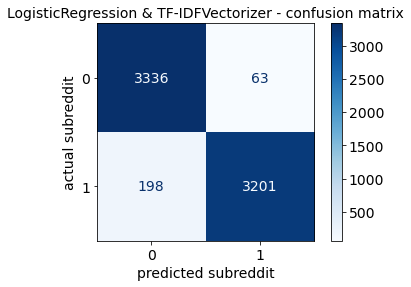

In [15]:
# plot and save confusion matrix
plt.rcParams.update({'font.size': 14}); # looked up in google how to change the font size on a sns heatmap
plot_confusion_matrix(logreg, X_test, y_test, cmap='Blues', values_format='d');
plt.title('LogisticRegression & TF-IDFVectorizer - confusion matrix',fontsize=14);
plt.xlabel('predicted subreddit', fontsize=14);
plt.ylabel('actual subreddit', fontsize=14);
plt.savefig('../images/df_tvec_logreg.jpeg');

---

### **3. Count Vectorizer - Random Forest**

In [141]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [31]:
count = 0 # count variable for specifying the model ID

model_params = {} # dictionary that will contain model parameters

In [33]:
## set modeling scaffolding ##

model_params = model_params # each time it's run, the model_params dict gets overwritten
count = count # overwriting count with each run

# defining a pipeline with 2 steps: CountVectorizer & LogisticRegression
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])

# set up the grid search parameters
params = {
    'cvec__max_features' : [6000],
    'cvec__min_df' : [4],
    'cvec__max_df' : [0.4],
    'cvec__ngram_range' : [(1,1)],
    'rf__n_estimators' : [50, 70],
    'rf__max_depth' : [7],
    'rf__min_samples_split' : [2],
    'rf__ccp_alpha' : [0.01]
}

# create grid search
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=6, verbose=1)

# fitting the model
gs.fit(X_train, y_train)

# increase the count variable
count += 1

# adding to our dictionary the best_params_ dictionary, in addition to the 'score'
gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_

# transform the params dictionary into a data frame, putting the model ID as the index
model_df = pd.DataFrame.from_dict(model_params, orient='index')

# print the data frame
model_df

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,rf__ccp_alpha,rf__max_depth,rf__min_samples_split,rf__n_estimators,score
model_1,0.4,6000,4,"(1, 1)",0.01,7,2,50,0.893712
model_2,0.4,6000,4,"(1, 1)",0.01,7,2,50,0.893712


In [142]:
# instantiating vectorizer
cvec = CountVectorizer(max_df = 0.4, min_df=4, max_features=6000, ngram_range=(1,1))

# apply cvec to the train data
X_train = cvec.fit_transform(X_train)

# apply cvec to the test data
X_test = cvec.transform(X_test)

In [143]:
# instantiate model
rf = RandomForestClassifier(random_state=42, ccp_alpha=0.01, max_depth=7, min_samples_split=2, 
                           n_estimators=50)

# fit the model to the train data
rf.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.01, max_depth=7, n_estimators=50,
                       random_state=42)

In [144]:
# training score
rf.score(X_train, y_train)

0.8969714534125489

In [145]:
# testing score
rf.score(X_test, y_test)

0.8939393939393939

In [146]:
# table of model scores
model_scores(X_test, y_test, rf)

,score,value
0,accuracy,0.893939
1,missclassification,0.106061
2,specificity,0.988820
3,recall_sensitivity,0.799059
4,precision,0.986202
5,f1,0.882821


In [147]:
# save table
df = model_scores(X_test, y_test, rf)
df['vectorizer'] = 'CountVectorizer'
df['model'] = 'RandomForest'
df.to_csv('../model_scores/df_cvec_rf.csv', index=False)

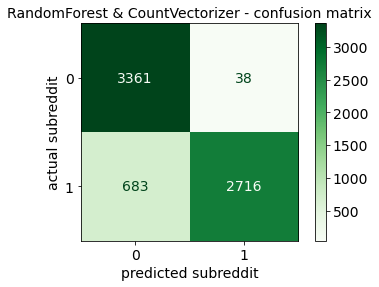

In [148]:
# plot and save confusion matrix
plt.rcParams.update({'font.size': 14});
plot_confusion_matrix(rf, X_test, y_test, cmap='Greens', values_format='d');
plt.title('RandomForest & CountVectorizer - confusion matrix',fontsize=14);
plt.xlabel('predicted subreddit', fontsize=14);
plt.ylabel('actual subreddit', fontsize=14);
plt.savefig('../images/df_cvec_rf.jpeg');

---

### **4. TF-IDF Vectorizer - Random Forest**

In [57]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [42]:
count = 0 # count variable for specifying the model ID

model_params = {} # dictionary that will contain model parameters

In [44]:
## set modeling scaffolding ##

model_params = model_params # each time it's run, the model_params dict gets overwritten
count = count # overwriting count with each run

# defining a pipeline with 2 steps: CountVectorizer & LogisticRegression
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rf', RandomForestClassifier(random_state=42))
])

# set up the grid search parameters
params = {
    'tvec__max_features' : [6000],
    'tvec__min_df' : [4],
    'tvec__max_df' : [0.4],
    'tvec__ngram_range' : [(1,1)],
    'rf__n_estimators' : [70,90],
    'rf__max_depth' : [7],
    'rf__min_samples_split' : [3],
    'rf__ccp_alpha' : [0.01]
}

# create grid search
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=6, verbose=1)

# fitting the model
gs.fit(X_train, y_train)

# increase the count variable
count += 1

# adding to our dictionary the best_params_ dictionary, in addition to the 'score'
gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_

# transform the params dictionary into a data frame, putting the model ID as the index
model_df = pd.DataFrame.from_dict(model_params, orient='index')

# print the data frame
model_df

Fitting 5 folds for each of 2 candidates, totalling 10 fits


,rf__ccp_alpha,rf__max_depth,rf__min_samples_split,rf__n_estimators,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,score
model_1,0.01,7,3,70,0.4,6000,4,"(1, 1)",0.887626
model_2,0.01,7,3,70,0.4,6000,4,"(1, 1)",0.887626


In [58]:
# instantiate vectorizer
tvec = TfidfVectorizer(max_df = 0.4, min_df=4, max_features=7000, ngram_range=(1,1))

# apply cvec to the train data
X_train = tvec.fit_transform(X_train)

# apply cvec to the test data
X_test = tvec.transform(X_test)

In [59]:
# instantiate model
rf = RandomForestClassifier(random_state=42, ccp_alpha=0.01, max_depth=7, min_samples_split=3, 
                           n_estimators=70)

# fit the model to the train data
rf.fit(X_train, y_train)

RandomForestClassifier(ccp_alpha=0.01, max_depth=7, min_samples_split=3,
                       n_estimators=70, random_state=42)

In [60]:
# training score
rf.score(X_train, y_train)

0.8573551263001485

In [61]:
# testing score
rf.score(X_test, y_test)

0.8528347406513872

In [154]:
# table of model scores
model_scores(X_test, y_test, rf)

,score,value
0,accuracy,0.865254
1,missclassification,0.134746
2,specificity,0.995587
3,recall_sensitivity,0.734922
4,precision,0.994031
5,f1,0.845061


In [155]:
# save table
df = model_scores(X_test, y_test, rf)
df['vectorizer'] = 'TF-IDFVectorizer'
df['model'] = 'RandomForest'
df.to_csv('../model_scores/df_tvec_rf.csv', index=False)

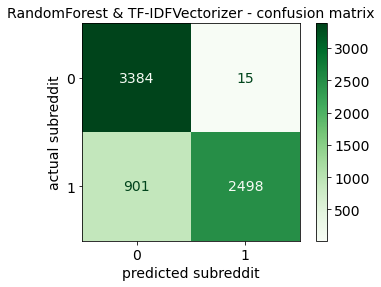

In [156]:
# plot and save confusion matrix
plt.rcParams.update({'font.size': 14});
plot_confusion_matrix(rf, X_test, y_test, cmap='Greens', values_format='d');
plt.title('RandomForest & TF-IDFVectorizer - confusion matrix',fontsize=14);
plt.xlabel('predicted subreddit', fontsize=14);
plt.ylabel('actual subreddit', fontsize=14);
plt.savefig('../images/df_tvec_rf.jpeg');

---

### **5. Count Vectorizer - Naive Bayes**

In [157]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [53]:
count = 0 # count variable for specifying the model ID

model_params = {} # dictionary that will contain model parameters

In [56]:
## set modeling scaffolding ##

model_params = model_params # each time it's run, the model_params dict gets overwritten
count = count # overwriting count with each run

# defining a pipeline with 2 steps: CountVectorizer & LogisticRegression
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

# set up the grid search parameters
params = {
    'cvec__max_features' : [7000,8000,9000,10000],
    'cvec__min_df' : [4],
    'cvec__max_df' : [0.4],
    'cvec__ngram_range' : [(1,1)]
}

# create grid search
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=6, verbose=1)

# fitting the model
gs.fit(X_train, y_train)

# increase the count variable
count += 1

# adding to our dictionary the best_params_ dictionary, in addition to the 'score'
gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_

# transform the params dictionary into a data frame, putting the model ID as the index
model_df = pd.DataFrame.from_dict(model_params, orient='index')

# print the data frame
model_df

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,cvec__max_df,cvec__max_features,cvec__min_df,cvec__ngram_range,score
model_1,0.4,6000,4,"(1, 1)",0.949500
model_2,0.4,8000,4,"(1, 1)",0.950515
model_3,0.4,9000,4,"(1, 1)",0.951457


In [158]:
# instantiate vectorizer
cvec = CountVectorizer(max_df = 0.4, min_df=4, max_features=9000, ngram_range=(1,1))

# apply to the train data
X_train = cvec.fit_transform(X_train)

# apply to the test data
X_test = cvec.transform(X_test)

In [159]:
# instantiate model
nb = MultinomialNB()

# fit the model to the train data
nb.fit(X_train, y_train)

MultinomialNB()

In [160]:
# training score
nb.score(X_train, y_train)

0.9602231560643385

In [161]:
# testing score
nb.score(X_test, y_test)

0.9558693733451015

In [162]:
# table of model scores
model_scores(X_test, y_test, nb)

,score,value
0,accuracy,0.955869
1,missclassification,0.044131
2,specificity,0.936452
3,recall_sensitivity,0.975287
4,precision,0.938828
5,f1,0.956710


In [163]:
# save table
df = model_scores(X_test, y_test, nb)
df['vectorizer'] = 'CountVectorizer'
df['model'] = 'NaiveBayes'
df.to_csv('../model_scores/df_cvec_nb.csv', index=False)

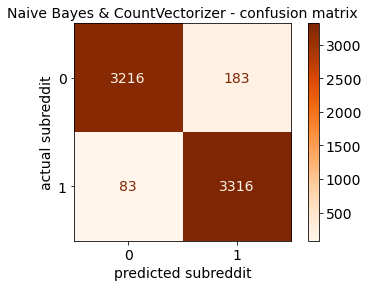

In [25]:
# plot and save confusion matrix
plt.rcParams.update({'font.size': 14});
plot_confusion_matrix(nb, X_test, y_test, cmap='Oranges', values_format='d');
plt.title('Naive Bayes & CountVectorizer - confusion matrix',fontsize=14);
plt.xlabel('predicted subreddit', fontsize=14);
plt.ylabel('actual subreddit', fontsize=14);
plt.savefig('../images/df_cvec_nb.jpeg');

---

### **6. TF-IDF Vectorizer - Naive Bayes**

In [16]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [17]:
count = 0 # count variable for specifying the model ID

model_params = {} # dictionary that will contain model parameters

In [68]:
## set modeling scaffolding ##

model_params = model_params # each time it's run, the model_params dict gets overwritten
count = count # overwriting count with each run

# defining a pipeline with 2 steps: CountVectorizer & LogisticRegression
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

# set up the grid search parameters
params = {
    'tvec__max_features' : [9000],
    'tvec__min_df' : [3],
    'tvec__max_df' : [0.6],
    'tvec__ngram_range' : [(1,1)]
}

# create grid search
gs = GridSearchCV(pipe, param_grid=params, cv=5, n_jobs=6, verbose=1)

# fitting the model
gs.fit(X_train, y_train)

# increase the count variable
count += 1

# adding to our dictionary the best_params_ dictionary, in addition to the 'score'
gs.best_params_['score'] = gs.best_score_
model_params[f'model_{count}'] = gs.best_params_

# transform the params dictionary into a data frame, putting the model ID as the index
model_df = pd.DataFrame.from_dict(model_params, orient='index')

# print the data frame
model_df

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,tvec__max_df,tvec__max_features,tvec__min_df,tvec__ngram_range,score
model_1,0.5,9000,3,"(1, 1)",0.955441
model_2,0.6,9000,3,"(1, 1)",0.955949


In [18]:
# instantiate vectorizer
tvec = TfidfVectorizer(max_df = 0.6, min_df=3, max_features=9000, ngram_range=(1,1))

# applying tvec to the train data
X_train = tvec.fit_transform(X_train)

# applying tvec to the test data
X_test = tvec.transform(X_test)

In [19]:
# instantiate model
nb = MultinomialNB()

# fit the model to the train data
nb.fit(X_train, y_train)

MultinomialNB()

In [20]:
# training score
nb.score(X_train, y_train)

0.9681930155049993

In [21]:
# testing score
nb.score(X_test, y_test)

0.96087084436599

In [22]:
# table of model scores
model_scores(X_test, y_test, nb)

,score,value
0,accuracy,0.960871
1,missclassification,0.039129
2,specificity,0.946161
3,recall_sensitivity,0.975581
4,precision,0.947699
5,f1,0.961438


In [23]:
# save table
df = model_scores(X_test, y_test, nb)
df['vectorizer'] = 'TF-IDFVectorizer'
df['model'] = 'NaiveBayes'
df.to_csv('../model_scores/df_tvec_nb.csv', index=False)

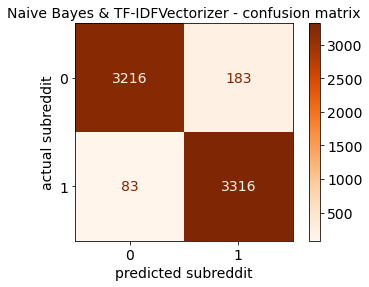

In [24]:
# plot and save confusion matrix
plt.rcParams.update({'font.size': 14});
plot_confusion_matrix(nb, X_test, y_test, cmap='Oranges', values_format='d');
plt.title('Naive Bayes & TF-IDFVectorizer - confusion matrix',fontsize=14);
plt.xlabel('predicted subreddit', fontsize=14);
plt.ylabel('actual subreddit', fontsize=14);
plt.savefig('../images/df_tvec_nb.jpeg');

---

In [121]:
# put together all the model scores data frames - saved into the folder model_scores
import os
import pandas as pd
files = os.listdir('../model_scores')

In [122]:
# check the first file(s)
files

['.ipynb_checkpoints',
 '.Rhistory',
 'df_cvec_logreg.csv',
 'df_cvec_nb.csv',
 'df_cvec_rf.csv',
 'df_tvec_logreg.csv',
 'df_tvec_nb.csv',
 'df_tvec_rf.csv']

In [123]:
# exclude the unnecessary files
files = files[2:]

In [130]:
# put the scores in the desired order
cols = ['accuracy', 'missclassification', 'recall_sensitivity', 'specificity', 'precision', 'f1']

# load the first file
model_info = pd.read_csv(f'../model_scores/{files[0]}')
# convert to wide format - looked up in google to remind myself how to use the pivot method
model_info = model_info.pivot(index=['model','vectorizer'], columns='score', values='value')[cols]

# loop to concatenate all data frames together
for file in range(1, len(files)):
    # load the next file in the line and convert to wide format
    df = pd.read_csv(f'../model_scores/{files[file]}')
    df = df.pivot(index=['model','vectorizer'], columns='score', values='value')[cols]
    # concatenate the data frames together
    model_info = pd.concat([model_info, df], axis=0)

In [131]:
model_info

,score,accuracy,missclassification,recall_sensitivity,specificity,precision,f1
model,vectorizer,,,,,,
LogisticRegression,CountVectorizer,0.958370,0.041630,0.934098,0.982642,0.981756,0.957335
NaiveBayes,CountVectorizer,0.955869,0.044131,0.975287,0.936452,0.938828,0.956710
RandomForest,CountVectorizer,0.893939,0.106061,0.799059,0.988820,0.986202,0.882821
LogisticRegression,TF-IDFVectorizer,0.961606,0.038394,0.941748,0.981465,0.980699,0.960828
NaiveBayes,TF-IDFVectorizer,0.960871,0.039129,0.975581,0.946161,0.947699,0.961438
RandomForest,TF-IDFVectorizer,0.865254,0.134746,0.734922,0.995587,0.994031,0.845061


In [132]:
# save the data frame with model info into the data folder
model_info.to_csv('../data/model_info_summary.csv')

---